<a href="https://colab.research.google.com/github/vberezina/machine-learning-basics/blob/main/practices/LR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ЛАБОРАТОРНАЯ РАБОТА №3. Деревья решений (Decision Trees)

## Теоретический минимум



Основная задача при построении дерева — решить, по какому признаку разделять данные на каждом шаге. Мы хотим, чтобы после разделения данные стали более «чистыми» (однородными).

###Энтропия Шеннона ($H$)

Энтропия — это мера хаоса или неопределенности в системе. Если в группе все объекты одного класса, энтропия равна 0. Если классы распределены поровну, энтропия максимальна.

$$H = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)$$

Где $p(x_i)$ — вероятность (доля) объектов $i$-го класса в узле.

### Информационный выигрыш (Information Gain)

Мы вычисляем энтропию до разбиения и после. Разница между ними — это информационный выигрыш. Алгоритм выбирает тот признак, который дает максимальный выигрыш.

## Учебная задача


In [ ]:
import numpy as np
from collections import Counter

class Node:
    """Вспомогательный класс для узла дерева."""
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature     # Индекс признака, по которому делим
        self.threshold = threshold # Порог деления
        self.left = left           # Левое поддерево
        self.right = right         # Правое поддерево
        self.value = value         # Значение, если узел листовой (ответ)

    def is_leaf_node(self):
        return self.value is not None


class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100):
        self.min_samples_split = min_samples_split # Мин. количество образцов для деления
        self.max_depth = max_depth                 # Макс. глубина дерева
        self.root = None

    def fit(self, X, y):
        """Метод обучения дерева."""
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_feats = X.shape

        if n_samples == 0:
            return Node(value=-1)

        n_labels = len(np.unique(y))

        # 1. Проверяем критерии остановки
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        # 2. Находим лучшее разбиение
        feat_idxs = np.random.choice(n_feats, n_feats, replace=False)
        best_feat, best_thresh = self._best_split(X, y, feat_idxs)

        # 3. Рекурсивно строим поддеревья
        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)

        return Node(best_feat, best_thresh, left, right)

    def _best_split(self, X, y, feat_idxs):
        """Поиск признака и порога с максимальным приростом информации."""
        best_gain = -1
        split_idx, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)

            for thr in thresholds:
                # Рассчитываем Information Gain
                gain = self._information_gain(y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self, y, X_column, threshold):
        # Родительская энтропия
        parent_entropy = self._entropy(y)

        # Создаем разбиение
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        # Средневзвешенная энтропия чаилдов
        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        # Прирост информации
        return parent_entropy - child_entropy

    def _entropy(self, y):
        """Формула энтропии: -sum(p * log2(p))"""
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log2(p) for p in ps if p > 0])

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _most_common_label(self, y):
        counter = Counter(y)
        return counter.most_common(1)[0][0]

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def print_tree(self, node=None, depth=0):
        """Рекурсивный вывод структуры дерева в консоль"""
        if node is None:
            node = self.root

        # Если это лист, выводим значение
        if node.is_leaf_node():
            print(f"{'  ' * depth}Результат: Класс {node.value}")
            return

        # Если это узел, выводим условие
        print(f"{'  ' * depth}[Признак {node.feature} <= {node.threshold:.2f}]")

        # Рекурсивно идем в ветки
        print(f"{'  ' * depth} Лево:")
        self.print_tree(node.left, depth + 1)
        print(f"{'  ' * depth} Право:")
        self.print_tree(node.right, depth + 1)


In [ ]:
from  sklearn import datasets
from sklearn.model_selection import train_test_split

# 1. Загрузка данных
data = datasets.load_iris()
X, y = data.data, data.target

# 2. Разделение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Создание и обучение нашей модели
# Ограничим глубину, чтобы дерево не переобучилось
clf = DecisionTree(max_depth=3)
clf.fit(X_train, y_train)

# 4. Предсказание
predictions = clf.predict(X_test)

# 5. Расчет точности
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

acc = accuracy(y_test, predictions)
print(f"Точность модели: {acc * 100:.2f}%")

Точность модели: 96.67%


In [ ]:
# Вывод в консоль:
clf.print_tree()

[Признак 3 <= 0.60]
 Лево:
  Результат: Класс 0
 Право:
  [Признак 2 <= 4.70]
   Лево:
    [Признак 3 <= 1.60]
     Лево:
      Результат: Класс 1
     Право:
      Результат: Класс 2
   Право:
    [Признак 3 <= 1.70]
     Лево:
      Результат: Класс 2
     Право:
      Результат: Класс 2


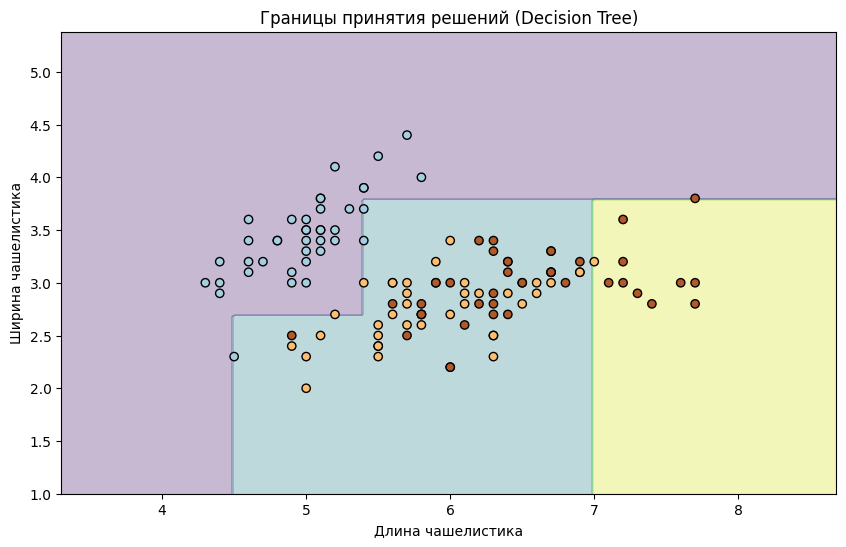

In [ ]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, model):
    # Берем только первые два признака для 2D визуализации
    X_plot = X[:, :2]
    model.fit(X_plot, y)

    h = .02  # шаг сетки
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlabel('Длина чашелистика')
    plt.ylabel('Ширина чашелистика')
    plt.title('Границы принятия решений (Decision Tree)')
    plt.show()

# Запуск
plot_decision_boundary(X_train, y_train, clf)

## Задания


### Задание №1. Дерево решений

1. Реализуйте алгоритм **Decision Tree (Дерево решений)**, используя только библиотеку numpy для математических вычислений.


2. В качестве критерия разбиения используйте **энтропию Шеннона** и метрику **Information Gain**.

3. Реализуйте механизм автоматической остановки дерева по двум параметрам: максимальная глубина (`max_depth`) и минимальное количество объектов в узле (`min_samples_split`).






### Задание №2. Обучение

Продемонстрируйте работоспособность кода, обучив его на любом стандартном датасете (например, Iris) и выведите итоговую точность (accuracy) на тестовой выборке.



## Контрольные вопросы

1. Почему используется логарифм по основанию 2 в формуле энтропии?

2. Что произойдет, если в признаке очень много уникальных значений? Почему информационный выигрыш может «ошибочно» посчитать такой признак лучшим?

3. В чем преимущество дерева решений перед kNN (С точки зрения интерпретируемости результата человеком)?

4. Когда следует прекратить рекурсию при построении дерева? (Назовите минимум два условия).

